# Objectives
Try to determine which news sources have the most reliable data to inform decisions in the stock market. We will be analyzing tweets from big companies such as Bloomberg, JP Morgan, and Goldman Sachs to see whether their tweets or the general sentiment of responses are correlated with increases or decreases in stock prices. We will use this as a benchmark to compare less popular sources of stock market data such as Reddit.

# Data Sources
- Twitter Kaggle Datasets
- Yahoo Finance API
- Twitter API
- Reddit API

# Hypothesis
We think that the sentiment of tweets from big stock market information sources will be reliable and have a positive correlation to stock prices. Less popular sources for stock information like Reddit will be more error prone, but will provide opportunities that yield high profit. The reasoning behind this is that people trust news from companies such as Bloomberg making those bets safer, but also less profitable. Random insights from Redditors may be wrong most of the time, but may "hit the jackpot."

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import yfinance as yf

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploration of [Twitter Kaggle Dataset](https://www.kaggle.com/davidwallach/financial-tweets)
This dataset contains financial tweets regarding stocks traded on NYSE, NASDAQ, and the S&P 500.

In [2]:
skiprows = [730, 2835, 3057, 3112, 3193, 3204, 3254, 3519, 4077, 4086, 4087, 4498]
tweet_df = pd.read_csv('./datasets/stockerbot-export.csv', skiprows=skiprows, parse_dates=['timestamp'])

# Drop last five rows since they seem to be in a different language
tweet_df = tweet_df[:-5]
tweet_df.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,2018-07-18 21:33:26+00:00,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,2018-07-18 22:22:47+00:00,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,2018-07-18 22:32:01+00:00,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,2018-07-18 22:52:52+00:00,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,2018-07-18 23:00:01+00:00,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


Text(0.5, 0, 'Number of Times Tweeted')

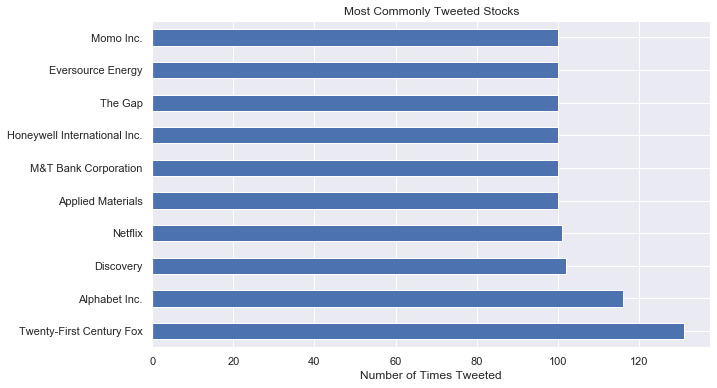

In [3]:
ax = tweet_df.company_names.value_counts().sort_values(ascending=False).head(10).plot.barh(figsize=(10, 6))
ax.set_title('Most Commonly Tweeted Stocks')
ax.set_xlabel('Number of Times Tweeted')

It is nice to see that this dataset has many tweets (around 100) for the most frequent companies. This will help us in determing the general sentiment around these companies over time to compare to stock prices. Many big names such as 21st Century Fox, Alphabet (parent company of Google), and Netflix also appear which are very established companies.

Text(0.5, 0, 'Twitter Users')

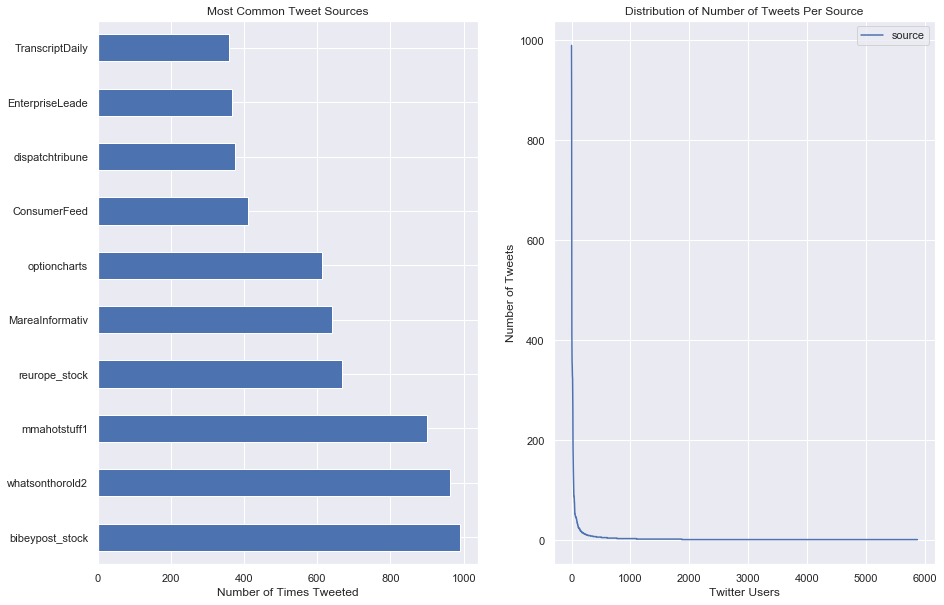

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

tweet_df.source.value_counts().head(10).plot.barh(ax=ax1, figsize=(15, 10))
ax1.set_title('Most Common Tweet Sources')
ax1.set_xlabel('Number of Times Tweeted')

tweet_df.source.value_counts().reset_index().plot(ax=ax2)
ax2.set_title('Distribution of Number of Tweets Per Source')
ax2.set_ylabel('Number of Tweets')
ax2.set_xlabel('Twitter Users')

This is also a nice feature of our data. The bar chart on the left worried me that our dataset was only going to have a few users that tweet a lot. This would create a lot of bias in any correlations we find. But if you look at the distribution graph on the right, it shows that there are only a few users who really tweet a lot; most users in this dataset only tweet a few times which gives us a better sample. Later we will try using the Twitter API to sample a lot of tweets from specific demographics of users.

Text(0, 0.5, 'Count')

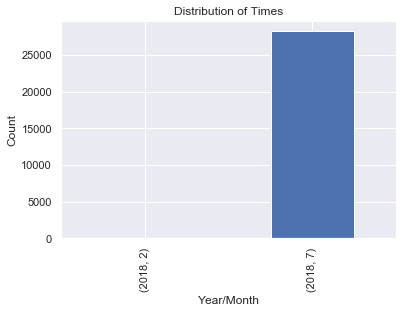

In [5]:
ax = tweet_df.groupby([tweet_df.timestamp.dt.year, tweet_df.timestamp.dt.month])['id'].count().plot(kind='bar')
ax.set_title('Distribution of Times')
ax.set_xlabel('Year/Month')
ax.set_ylabel('Count')

The one unfortunate thing about this dataset is it primarily includes tweets from July 2018 and a few tweets it seems from February 2018. We will likely need to pull in more data using the Twitter API, but this dataset will provide a good starting place.

# Collecting Stock Data Through the Yahoo Finance API
We were originally going to compare this Twitter dataset against some Kaggle stocks datasets. Given that our Twitter dataset only covers one month and the Kaggle datasets are very large, we are instead going to use the yfinance Python module to collect data for this specific month.

In [6]:
# Lets identify the top 30 stocks (based on frequency) from our Twitter dataset and use that with yfinance
common_tickers = tweet_df.symbols.value_counts().sort_values(ascending=False).head(30)
common_tickers.head()

NFLX    101
ES      100
GPS     100
MTB     100
MOMO    100
Name: symbols, dtype: int64

In [7]:
# Queries Yahoo Finance API for these stocks on the month of July 2018
stocks_df = yf.download(tickers=list(common_tickers.index), start='2018-07-01', end='2018-07-31')
stocks_df.head()

[*********************100%***********************]  30 of 30 completed

3 Failed downloads:
- FOX: Data doesn't exist for startDate = 1530417600, endDate = 1533009600
- ARNC: Data doesn't exist for startDate = 1530417600, endDate = 1533009600
- OMG: No data found for this date range, symbol may be delisted


Adj Close                                         \
                          ABBV       AMAT ARNC         BLK          D   
Date                                                                    
2018-07-02 00:00:00  80.599098  43.812244  NaN  465.989349  61.225769   
2018-07-03 00:00:00  81.031921  42.968220  NaN  458.311768  61.995003   
2018-07-05 00:00:00  81.785034  43.582054  NaN  458.955444  62.379616   
2018-07-06 00:00:00  83.897171  44.243843  NaN  458.684906  62.630074   
2018-07-09 00:00:00  84.001045  44.617893  NaN  470.261902  60.894825   

                                                                      ...  \
                           DFS         ES         ESS FOX        GPS  ...   
Date                                                                  ...   
2018-07-02 00:00:00  66.760170  55.400024  220.294998 NaN  28.312382  ...   
2018-07-03 00:00:00  66.187805  55.869362  220.294998 NaN  28.767450  ...   
2018-07-05 00:00:00  66.225349  56.057095  222.607773 NaN  28.196383  ...   
2018-07-06 00:00:00  66.093971  56.610909  223.838806 NaN  27.893003  ...   
2018-07-09 00:00:00  67.576477  54.874374  222.589127 NaN  27.500397  ...   

                      Volume                                           \
                        MOMO      MTB      NFLX     NTNX OMG       ON   
Date                                                                    
2018-07-02 00:00:00  4815300   732600   8142500  2096200 NaN  4726700   
2018-07-03 00:00:00  2118100   383100   5280300  1296300 NaN  2400500   
2018-07-05 00:00:00  3498100   680100   8448900  2332100 NaN  7132400   
2018-07-06 00:00:00  4059300   829500   8629600  2291100 NaN  4202200   
2018-07-09 00:00:00  5586900  1108800  11127500  2527400 NaN  3749400   

                                                         
                          PBR    SQQQ      TEL      UPS  
Date                                                     
2018-07-02 00:00:00  14640200  749600  1671100  2252300  
2018-07-03 00:00:00  15707700  509200   815400  1145700  
2018-07-05 00:00:00  21271900  841100  1521900  2866800  
2018-07-06 00:00:00  13076300  837000   986000  2022400  
2018-07-09 00:00:00  18007000  617600  1140300  2103600  

[5 rows x 180 columns]

# Cleaning Yahoo Finance Data

In [8]:
# Only want Open, Close, and Volume. Drop the rest
stocks_df.drop(['Adj Close', 'Low', 'High'], axis=1, inplace=True)

# Columns are multi-indexed, so flatten this
stocks_df.columns = ['_'.join(multi_col) for multi_col in stocks_df.columns]

# Drop FOX, OMG, and ARNC cols since we weren't able to get data for them
stocks_df.drop(list(stocks_df.filter(regex='(FOX)|(OMG)|(ARNC)$')), axis=1, inplace=True)

stocks_df.head()

,Close_ABBV,Close_AMAT,Close_BLK,Close_D,Close_DFS,Close_ES,Close_ESS,Close_GPS,Close_GRPN,Close_HLT,...,Volume_MHK,Volume_MOMO,Volume_MTB,Volume_NFLX,Volume_NTNX,Volume_ON,Volume_PBR,Volume_SQQQ,Volume_TEL,Volume_UPS
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02 00:00:00,93.110001,45.680000,499.519989,68.449997,71.150002,59.020000,236.220001,31.730000,86.199997,79.300003,...,839600,4815300,732600,8142500,2096200,4726700,14640200,749600,1671100,2252300
2018-07-03 00:00:00,93.610001,44.799999,491.290009,69.309998,70.540001,59.520000,236.220001,32.240002,85.199997,79.449997,...,405700,2118100,383100,5280300,1296300,2400500,15707700,509200,815400,1145700
2018-07-05 00:00:00,94.480003,45.439999,491.980011,69.739998,70.580002,59.720001,238.699997,31.600000,87.599998,79.690002,...,414600,3498100,680100,8448900,2332100,7132400,21271900,841100,1521900,2866800
2018-07-06 00:00:00,96.919998,46.130001,491.690002,70.019997,70.440002,60.310001,240.020004,31.260000,87.199997,80.559998,...,479100,4059300,829500,8629600,2291100,4202200,13076300,837000,986000,2022400
2018-07-09 00:00:00,97.040001,46.520000,504.100006,68.080002,72.019997,58.459999,238.679993,30.820000,96.599998,80.940002,...,426000,5586900,1108800,11127500,2527400,3749400,18007000,617600,1140300,2103600


This is a lot easier to work with. The data is not exactly tidy since the tickers are included in column names, but this has every price lined up by the date which should make it easier to graph. When graphing, we will just use regex to select the columns corresponding to a specific ticker. Such a dataset would be tidy.

# NLP and Sentiment Analysis on Tweets
Now that we have some tweets and stock price information for the corresponding time period, we can begin to do some analysis. We will start by doing some NLP on the Tweets and then we can compare them to changes in stock price over time.

We will be using VADER (Valence Aware Dictionary and Sentiment Reasoner) to figure out the sentiment. This gives us a reliable way of determining sentiment without labeling our own data and generating models. This rule-based analysis tool was explicitly designed for social media data which is perfect for this scenario.

In [9]:
# First filter for Tweets talking about our common tickers
relevant_tickers = tweet_df[tweet_df.symbols.isin(common_tickers.index)].reset_index()

print(relevant_tickers.shape)
relevant_tickers.head()

(2906, 9)


,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,Senate wants emergency alerts to go out throug...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,Templeton and BlackRock say now's the time to ...,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,In 2 days I doubled my account with the option...,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,Weekly Recap: $HSY price moved 4.28% since pos...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,$AR $CGC $DAVE $GNC $HSY $ICON $KMB $M $PEP $P...,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Cleaning Up Tweets with NLTK

In [10]:
tt = TweetTokenizer()

def clean_tweet(s):
    # Removing punctuation and stop words (e.g 'the', 'is', 'which')
    return ' '.join(wd for wd in tt.tokenize(s.lower()) if wd.isalnum() and wd not in set(stopwords.words('english')))

# Sample usage
print(relevant_tickers.text[1])
print(clean_tweet(relevant_tickers.text[1]))

Templeton and BlackRock say now's the time to buy emerging markets https://t.co/h4z90nxqwH https://t.co/6FkVrZlu3j
templeton blackrock say time buy emerging markets


In [11]:
# Now apply this cleanup to every tweet
relevant_tickers.text = relevant_tickers.text.apply(clean_tweet)
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Perform Sentiment Analysis with Vader

In [13]:
sent = SentimentIntensityAnalyzer()
relevant_tickers['sentiment'] = relevant_tickers.text.apply(lambda s: sent.polarity_scores(s)['compound'])

# a compound sentiment value is positive if >= 0.05, negative if <= -0.05, neutral if in between
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified,sentiment
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True,-0.3818
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True,0.0000
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False,0.0000
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False,-0.2960
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False,0.0000


So now each tweet has a value ranging from -1 to 1 representing how positive/negative the sentiment of the tweet is. My current worry is that many of these tweets are factual in nature meaning the sentiment score will not be indicative of stock performance. Later we will try to look at other things such as Twitter replies and compare sentiment of those tweets to stock performance.

## Sentiment vs Stock Price Performance
Now lets see how these sentiments over time correlate against stock performance

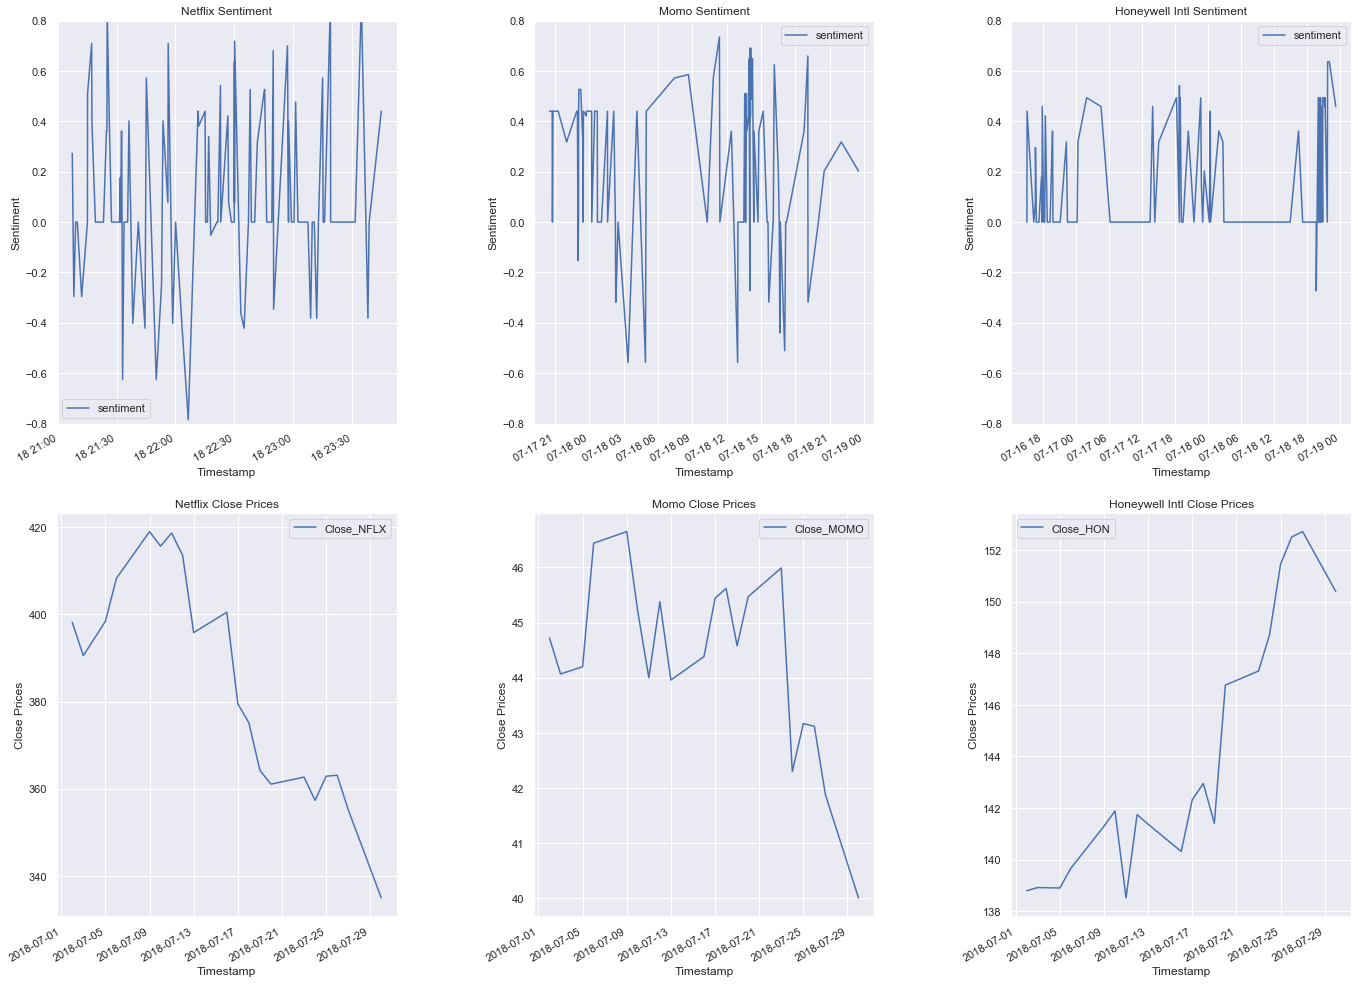

In [14]:
fig, axs = plt.subplots(2, 3)
syms = relevant_tickers.symbols
fig.tight_layout(pad=0.25)

# Graph Sentiment vs Time for 3 companies
axs[0, 0].set_ylim([-0.8, 0.8]); axs[0, 1].set_ylim([-0.8, 0.8]); axs[0, 2].set_ylim([-0.8, 0.8])
sentiment_kwargs = {'x': 'timestamp', 'y': 'sentiment', 'figsize': (20, 16), 'ylabel': 'Sentiment', 'xlabel': 'Timestamp'}

relevant_tickers[syms == 'NFLX'].plot.line(ax=axs[0, 0], title='Netflix Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'MOMO'].plot.line(ax=axs[0, 1], title='Momo Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'HON'].plot.line(ax=axs[0, 2], title='Honeywell Intl Sentiment', **sentiment_kwargs)

# Graph stock performance vs Time for 3 companies
price_kwargs = {'xlabel': 'Timestamp', 'ylabel': 'Close Prices', 'use_index': True}

stocks_df.plot.line(y='Close_NFLX', ax=axs[1, 0], title='Netflix Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_MOMO', ax=axs[1, 1], title='Momo Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_HON', ax=axs[1, 2], title='Honeywell Intl Close Prices', **price_kwargs)

Unfortunately, it does not look like there is any real correlation between the sentiment and stock prices here. I hypothesize that the problem is just with our current Twitter dataset since these tweets do not contain any real sentiment, yet we are still tagging it with a sentiment value. Now let's move on to doing similar analysis but with tweets pulled in from the Twitter API to see if this remedies the issue.

# Twitter API
The Kaggle Twitter dataset was interesting and provided a starting place for analysis. Since this data was already labeled with information such as the source and stocks that it mentioned, it was easy to compare against information pulled from the Yahoo Finance API. To try and find some more insight into indicators of stock performance we will look at Twitter replies to try and find correlations since these will likely be more opinionated and make use of our sentiment tagging.

# Reddit API
Twitter has been commonly used by large companies to report to the general public on news. We will now look at the Reddit API to see if we can generate more interesting correlations to provide insight into stock performance.